In [1]:
import os
user = os.getenv('USER')
import sys
sys.path.insert(0, f'/Home/{user}/py/stereoid')

In [2]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import pyproj

import drama.utils as drtls
from drama.io import cfg as cfg
from drama.geo import SingleSwathBistatic

import stereoid.sar_performance as strsarperf
import stereoid.oceans.tools.observation_tools as obs_tools
from stereoid.sea_ice import FwdModel, SceneGenerator

from harmony23lib import (
    read_nextsim_data,
    create_swath_grids,
    interpolate_nextsim_on_swath,
    compute_nextsim_uv,
)

In [3]:
# Run ID
mode = "IWS"
runid='2021_1_seaice'

# stereoid path
path=f'/data1/{user}/stereoid'
pardir=path + '/PAR/'
parfile=pardir + 'Hrmny_' + '2021_1_seaice' + '.cfg'
cfgdata = cfg.ConfigFile(drtls.get_par_file(parfile))
main_dir=path + ''

# input neXtSIM files
model_dir=path + '/nextsim/'

# radar model
#fstr_dual = strsarperf.sarperf_files(main_dir, rx_dual_name, mode=mode, runid=runid) # at the moment IW only I think
fstr_ati = strsarperf.sarperf_files(main_dir, 'tud_2020_tripple_ati', mode=mode, runid=runid)
fstr_s1 = strsarperf.sarperf_files(main_dir, 'sentinel', mode=mode, runid=runid, is_bistatic=False)

# some additional settings
x_res=cfgdata.sar.gr_res # is readily set 
y_res=cfgdata.sar.gr_res # make it equal to the monostatic ground-range resolution
t_res=cfgdata.orbit.timestep # along-track time resolution of generated swath
sp=[complex(1.6,0.07), 0.0030, 0.015, 0.04] 
ip=[complex(3.65,0.38), 0.0030, 0.015] 
pol='hh+hv'
prod_res = np.sqrt(x_res * y_res)
b_ati=10
t_orb=12/175

inc_m_deg=31.1
inc_m = np.deg2rad(inc_m_deg)
along_track_separation=375e3 # should be consistent with the PAR file
obs_geo = obs_tools.build_geometry(parfile, inc_m, dau=along_track_separation)

fwdm = FwdModel(parfile,sp,ip)# initialize forwaes model
sgm = SceneGenerator(fwdm,x_res,y_res,n_orbs=2) # initialize scene generator
proj = pyproj.proj.Proj('+proj=stere +lat_0=90 +lat_ts=75')
n_orbits=10

In [4]:
# create Swath generator
swb = SingleSwathBistatic(par_file=parfile, dau=along_track_separation, n_orbits=1)
swth_bst = next(swb)

In [5]:
# read coordinates of nodes, u, v and concentration and triangulation from nextsim mesh
# X, Y are in polar stereographic projection
filename = f'/data1/{user}/stereoid/nextsim/exp_00000/field_20070101T000000Z.npz'
x, y, v_e, v_n, c, t = read_nextsim_data(filename, proj)

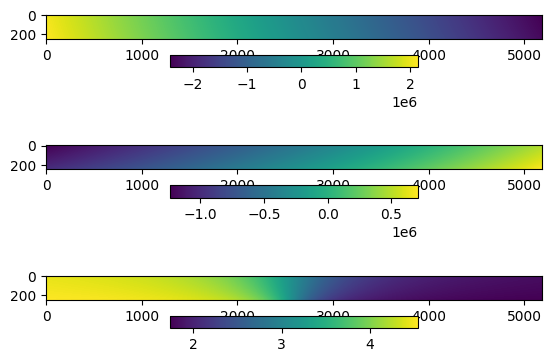

In [6]:
# create swath grids with X, Y in polar stereographic projection
x_sz, y_sz, nor_sz = create_swath_grids(swth_bst, proj, t_res, y_res)

plt.subplot(3,1,1)
plt.imshow(x_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,2)
plt.imshow(y_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,3)
plt.imshow(nor_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.show()

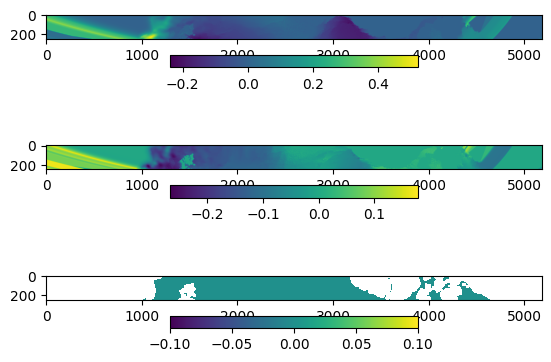

In [7]:
# Create grids with neXtSIM U, V, landmask and ice mask in SWATH projection
v_e_sz, v_n_sz, landmask, icemask = interpolate_nextsim_on_swath(x, y, v_e, v_n, c, t, x_sz, y_sz)

plt.subplot(3,1,1)
plt.imshow(v_e_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,2)
plt.imshow(v_n_sz.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(3,1,3)
plt.imshow(icemask.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.show()

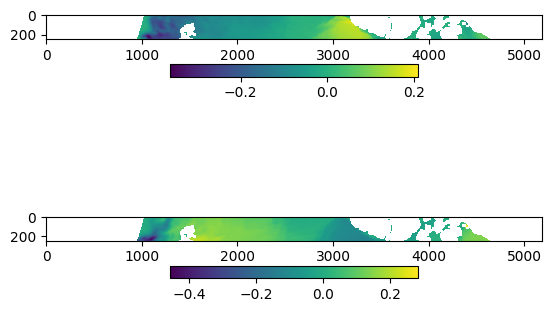

In [8]:
# Compute range and azimuth components of U and V
u_int, v_int = compute_nextsim_uv(v_e_sz, v_n_sz, landmask, nor_sz)

plt.subplot(2,1,1)
plt.imshow(u_int.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.subplot(2,1,2)
plt.imshow(v_int.T)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.show()